### Examples

In the following notebook you can try several examples. If you are interested you can also download the notebook and the ``trussopt.py`` file and explore the script further.

In [1]:
import trussopt
import itertools
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

**Example 1: Simple Truss**

Example 1 shows how to manually state a problem for the truss optimizer to solve. It is possible to define all the nodes, lines between nodes, supports and loads by hand. This way the problem you want to solve can be highly tunable but it becomes quite a lot of work for a larger problem.

In [2]:
# Node data as list of XYZ coordinates. z=0 for 2D trusses
nodes = [
    [0.0, 0.0, 0.0],   # Node 0
    [1.0, 1.0, 0.0],   # Node 1
    [2.0, 0.0, 0.0],   # Node 2
    [3.0, 1.0, 0.0],    # Node 3
    [4.0, 0.0, 0.0],    # Node 4
    [5.0, 1.0, 0.0],    # Node 5
    [6.0, 0.0, 0.0],    # Node 6
]

# Line data as list of tuples (start node index, end node index, include in starting set, tensile strength, compressive strength)
lines = [
    (0, 1, True, 1, 1),  # Line 0 between Node 0 and Node 1
    (0, 2, True, 1, 1),  # Line 1 between Node 0 and Node 2
    (1, 2, True, 1, 1),  # Line 2 between Node 1 and Node 2
    (1, 3, True, 1, 1),  # Line 3 between Node 2 and Node 3
    (2, 3, True, 1, 1),  # Line 4 between Node 2 and Node 3
    (2, 4, True, 1, 1),  # Line 5 between Node 2 and Node 4
    (3, 4, True, 1, 1),  # Line 6 between Node 3 and Node 4
    (3, 5, True, 1, 1),  # Line 7 between Node 3 and Node 5
    (4, 5, True, 1, 1),  # Line 8 between Node 4 and Node 5
    (4, 6, True, 1, 1),  # Line 9 between Node 4 and Node 6
    (5, 6, True, 1, 1),  # Line 10 between Node 5 and Node 6
]

# Support data as a dictionary of node indices to support conditions
supports = {
    0: [0, 0, 0],  # Node 0 is fixed in all directions
    6: [1, 0, 0],  # Node 6 is free in x direction
}

# Load data as a list of dictionary of node indices to load vectors
loads = [{
    2: [0, 0.5, 0],    # Load on Node 2, the value also has effect on the size of the arrow
    4: [0, 0.5, 0]     # Load on Node 4
}]

# Joint cost
joint_cost = 0.0  # Adding cost of joints to members

For the optimization itself we simply call to functions from the ``trussopt.py``. First with `trussopt.lo` we solve the optimization problem we defined above. Take a look at the documentation to understand what the parameters are and what the function returns. With ``trussopt.lo_plot()`` the result is plotted. Does the joint cost have any effect on this problem?

Note that we include all members in the starting set for now.

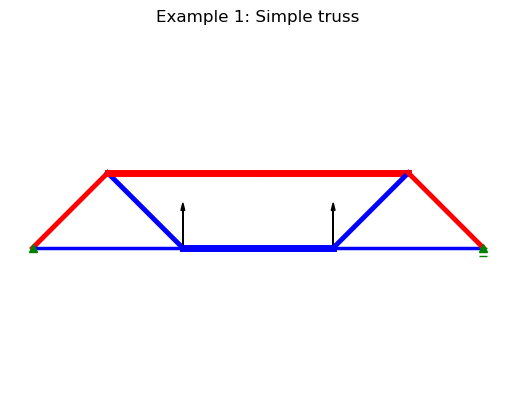

In [3]:
Nd, Cn, a, q = trussopt.lo(nodes, lines, supports, loads, joint_cost=0.0)
trussopt.lo_plot(Nd, Cn, a, q, supports, loads, threshold=0.1, str='Example 1: Simple truss', update=True, plane='xy')

**Example 2: Creating a 2D grid with Itertools**

In the second example we solve the problem from figure 1. First we need to define the grid of points and the lines. With the funcion `generate_3D_grid` we use itertools to make all possible combination between nodes and store the lines in the correct array. The input for the member adding scheme can also be created in this function. We can for example say that every line longer than 2 is not included in the initial set. We define ``plot_grid`` to check if we succesfully created the wished grid.

(note that we directly define the 3D functions but it also works for 2D problems)

In [4]:
def generate_3D_grid(x, y, z):
    
    # Create a list to store all the nodes
    nodes = [(i, j, k) for i in range(x) for j in range(y) for k in range(z)]
    
    # Create a mapping from node positions to point numbers
    node_to_number = {node: index for index, node in enumerate(nodes)}
    
    # Use itertools.combinations to generate all pairs of nodes (lines between nodes)
    lines = []
    for node1, node2 in itertools.combinations(nodes, 2):
        point1 = node_to_number[node1]
        point2 = node_to_number[node2]
        if ((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2 + (node1[2] - node2[2])**2)**0.5 > 2:
            lines.append((point1, point2, False, 1, 1))
        else: 
            lines.append((point1, point2, True, 1, 1))
    
    return nodes, lines

def plot_grid(nodes, lines):
    fig, ax = plt.subplots()
    
    # Plot nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'bo')  # 'bo' means blue color, circle marker
        for i, node in enumerate(nodes): #create the node index again
            ax.text(node[0], node[1], str(i), fontsize=12, ha='right')
    
    # Plot lines
    for line in lines:
        if line[2] == True:
            node1 = nodes[line[0]]
            node2 = nodes[line[1]]
            ax.plot([node1[0], node2[0]], [node1[1], node2[1]], 'k-')  # 'k-' means black color, solid line
        else:
            node1 = nodes[line[0]]
            node2 = nodes[line[1]]
            ax.plot([node1[0], node2[0]], [node1[1], node2[1]], 'r-')
    
    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Grid of Nodes and Lines')
    plt.show()

If we generate and plot the grid we can check if all nodes and lines are created correctly and if the longer lines are indeed excluded from the intitial set. The node numbers are included in the plot so we can easily pick points to add supports and loads.

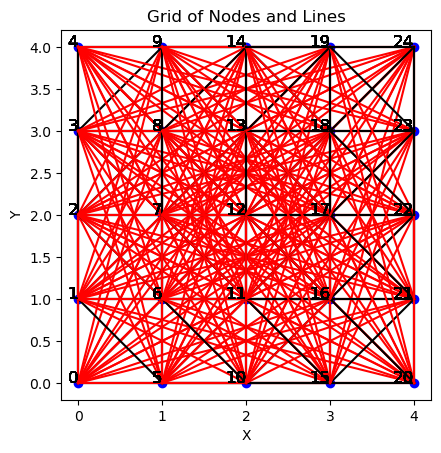

In [5]:
x, y, z = 5, 5, 1 #set z the 1 to make it 2D
nodes, lines = generate_3D_grid(x, y, z)
plot_grid(nodes, lines)

That looks like what we want! Now we can easily see which at which nodes we should define the supports and the loads and run the optimizer. Change the `joint_cost` and see what happens.

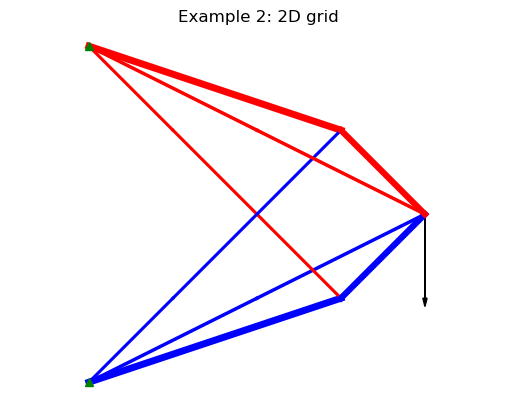

In [6]:
# Support data as a dictionary of node indices to support conditions
supports = {
    0: [0, 0, 0],  # Node 0 is fixed in all directions
    4: [0, 0, 0]  # Node 4 is fixed in all directions
}

# Load data as a list of dictionary of node indices to load vectors
loads = [{
    22: [0, -1, 0]    # Load on Node 22
}]

# Joint cost
joint_cost = 0.0  # Adding cost of joints to members, the number is a bit arbitrary but here every number higher than 0 will change the outcome

Nd, Cn, a, q = trussopt.lo(nodes, lines, supports, loads, joint_cost=joint_cost)
trussopt.lo_plot(Nd, Cn, a, q, supports, loads, threshold=0.1, str='Example 2: 2D grid', update=True, plane='xy')

**Example 3: Half wheel**

For the third example we want to create a half wheel supported at the ends and with one load in the middle. It will take a long time to plot an example grid of this size, but we know from the previous example how the numbering works. So we can quite easily work out where the supports and loads are. Try again to change the `joint_cost` and see what happens this time

In [7]:
x, y, z = 11, 5, 1  # Example grid dimensions (3x3x3)
nodes, lines = generate_3D_grid(x, y, z)
#print((nodes))
#print(lines)
#plot_grid(nodes, lines) #plotting this will take a long time

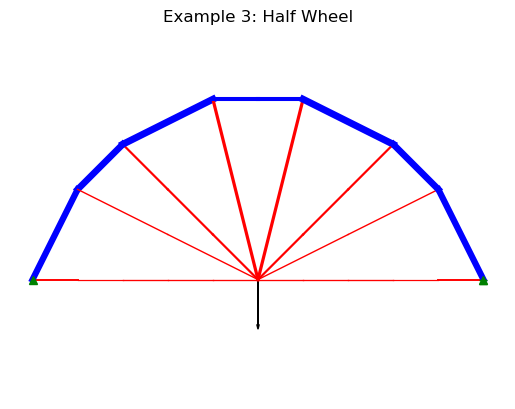

In [8]:
# Support data as a dictionary of node indices to support conditions
supports = {
    0: [0, 0, 0],  # Node 0 is fixed in all directions
    50: [1, 0, 0]  # Node 50 is free in x direction  
}

# Load data as a list of dictionary of node indices to load vectors
loads = [{
    25: [0, -1, 0]  # Load on Node 25
}]

# Joint cost
joint_cost = 0.0  # Adding cost of joints to members, the number is a bit arbitrary but here every number higher than 0 will change the outcome

Nd, Cn, a, q = trussopt.lo(nodes, lines, supports, loads, joint_cost=joint_cost)
trussopt.lo_plot(Nd, Cn, a, q, supports, loads, threshold=0.1, str='Example 3: Half Wheel', update=True, plane='xy')

**Example 4: Non-convex domain**

For the fourth example we create a non-convex domain. We define an area that we want to keep free of lines before we start the optimization.

In [9]:
def generate_non_convex(x, y, exclude_rect=None):
    """
    Generate a 2D grid of nodes and lines, excluding a rectangular section if specified.
    
    Parameters:
    x (int): Number of nodes along the x-axis.
    y (int): Number of nodes along the y-axis.
    exclude_rect (tuple): A tuple (x1, y1, x2, y2) defining the rectangular section to exclude.
                          (x1, y1) is the bottom-left corner and (x2, y2) is the top-right corner.
    
    Returns:
    nodes (list): List of node coordinates.
    lines (list): List of lines between nodes.
    """
    # Create a list to store all the nodes
    nodes = [(i, j) for i in range(x+1) for j in range(y+1)]
    
    # Exclude nodes within the specified rectangular section
    if exclude_rect:
        x1, y1, x2, y2 = exclude_rect
        nodes = [(i, j) for i, j in nodes if not (x1 <= i <= x2 and y1 <= j <= y2)]
    
    # create the 4 corners of the rectangle
    offset = 0.1 # offset to make sure the lines between the corners are still possible
    rect = [(x1+offset, y1+offset), (x2-offset, y1+offset), (x2-offset, y2-offset), (x1+offset, y2-offset)]

    # Create a mapping from node positions to point numbers
    node_to_number = {node: index for index, node in enumerate(nodes)}
    
    # Use itertools.combinations to generate all pairs of nodes (lines between nodes)
    lines = []
    for node1, node2 in itertools.combinations(nodes, 2):
        # Check if the line crosses the excluded rectangle
        if exclude_rect:
            x1, y1, x2, y2 = exclude_rect
            def ccw(A, B, C): # Helps to determine if the points are in a clockwise or counter clockwise order.
                return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

            def intersect(A, B, C, D): # Function to check if two line segments intersect by comparing the orientations of their endpoints.
                return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

            if any(intersect(node1, node2, rect[i], rect[(i + 1) % 4]) for i in range(4)):
                continue
            
        point1 = node_to_number[node1]
        point2 = node_to_number[node2]
        lines.append((point1, point2, True, 1, 1))
    
    # Add z = 0 coordinate to all nodes
    nodes = [(i, j, 0) for i, j in nodes]

    # Add z = 0 coordinate to all lines
    lines = [(point1, point2, True, 1, 1) for point1, point2, _, _, _ in lines]

    return nodes, lines

We define a 10 x 10 grid and let the newly defined function fill it with a grid of points and subtract all points and lines that pass the rectangle we want to leave out. The resulting grid is printed to check if it worked.

[(0, 0, 0), (0, 1, 0), (0, 2, 0), (0, 3, 0), (0, 4, 0), (0, 5, 0), (0, 6, 0), (0, 7, 0), (0, 8, 0), (0, 9, 0), (0, 10, 0), (1, 0, 0), (1, 1, 0), (1, 2, 0), (1, 3, 0), (1, 4, 0), (1, 5, 0), (1, 6, 0), (1, 7, 0), (1, 8, 0), (1, 9, 0), (1, 10, 0), (2, 0, 0), (2, 1, 0), (2, 2, 0), (2, 8, 0), (2, 9, 0), (2, 10, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0), (3, 8, 0), (3, 9, 0), (3, 10, 0), (4, 0, 0), (4, 1, 0), (4, 2, 0), (4, 8, 0), (4, 9, 0), (4, 10, 0), (5, 0, 0), (5, 1, 0), (5, 2, 0), (5, 8, 0), (5, 9, 0), (5, 10, 0), (6, 0, 0), (6, 1, 0), (6, 2, 0), (6, 8, 0), (6, 9, 0), (6, 10, 0), (7, 0, 0), (7, 1, 0), (7, 2, 0), (7, 8, 0), (7, 9, 0), (7, 10, 0), (8, 0, 0), (8, 1, 0), (8, 2, 0), (8, 8, 0), (8, 9, 0), (8, 10, 0), (9, 0, 0), (9, 1, 0), (9, 2, 0), (9, 3, 0), (9, 4, 0), (9, 5, 0), (9, 6, 0), (9, 7, 0), (9, 8, 0), (9, 9, 0), (9, 10, 0), (10, 0, 0), (10, 1, 0), (10, 2, 0), (10, 3, 0), (10, 4, 0), (10, 5, 0), (10, 6, 0), (10, 7, 0), (10, 8, 0), (10, 9, 0), (10, 10, 0)]
[(0, 1, True, 1, 1), (0, 2, Tru

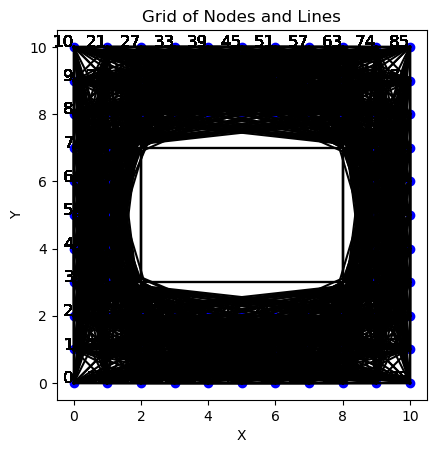

In [15]:
# Example usage
x, y = 10, 10
exclude_rect = (2, 3, 8, 7)  # Exclude the rectangular section from (2, 3) to (8, 7)
nodes, lines = generate_non_convex(x, y, exclude_rect)
print(nodes)
print(lines)
plot_grid(nodes, lines) #comment this to make it run faster

Now we only have to define the supports and loads and we can run the optimizer again

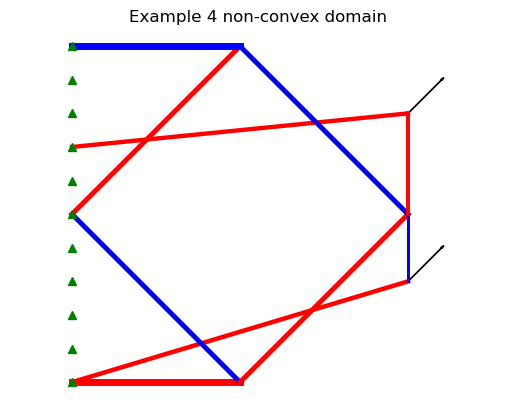

In [14]:
supports = {
    0: [0, 0, 0],
    1: [0, 0, 0],
    2: [0, 0, 0],
    3: [0, 0, 0],
    4: [0, 0, 0],
    5: [0, 0, 0],
    6: [0, 0, 0],
    7: [0, 0, 0],
    8: [0, 0, 0],
    9: [0, 0, 0],
    10: [0, 0, 0],
}

# Load data as a list of dictionary of node indices to load vectors
loads = [{
    83: [1, 1, 0],
    78: [1, 1, 0],
}]

# Joint cost
joint_cost = 2.5 

Nd, Cn, a, q = trussopt.lo(nodes, lines, supports, loads, joint_cost=joint_cost)
trussopt.lo_plot(Nd, Cn, a, q, supports, loads, threshold=0.01, str='Example 4 non-convex domain', update=True, plane='xy')

**Postprocessing:**

Now we created quite a complicated structure and there are some interesting things to note:

You might have wondered what the ``treshold`` in the ``lo_plot`` is doing. The treshold is the minimum cross-section a member should have to be plotted. Note that we only avoid plotting very small members, but not avoid them in the optimization function itself. If this value is set too high, we might plot a structure with weird inconsistencies like members only attached on one end or kinks or changes in cross-section.

In this example changing the ``joint_cost`` matters a lot. Try different values, also in combination with changing the ``treshold``. You should be able to see that with ``joint_cost = 0`` the plot shows inconsistencies in member cross-section even if we set the ``threshold`` to a very low value.

Note how the optimizer only uses a limited set of the supports.